### Udacity Data Science Nanodegree
### Project 3: Disaster Recovery Pipeline
---

# Notebook 3 of 3: ML Pipeline Preparation

## by Juanita Smith
---


- [1. Import libraries and load data from database](#step1)
- [2. Write a tokenization function to process text data](#step2)
- [3. Build a machine learning pipeline using `XGBOOST`](#step3)
- [4. Set a baseline - Train and evaluate pipeline](#step4)
- [5. Improve the model with `GridSearchCV` and `Optuna`](#step5)
- [6. Further improve the model](#step6)
    - [Try XGBOOST `multi_output_tree`](#step61)
    - [Add `starting_verb` feature](#step62)
    - [Use `OpenAI` to create embeddings instead of using tokenizer](#step63)
- [7. Export final model as a pickle file](#step7)
- [References](#ref)

<a class="anchor" id='step1'></a>
<span style="color:blue; font-size:25px; line-height:30px; font-family: Calibri;">1. Import libraries and load data from database</span>

In [1]:
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# import libraries

from sqlalchemy import create_engine
import os

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, precision_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from shutil import rmtree

# save and load models
from pickle import dump, load

# clear the garbage to free memory as we are working with huge datasets
import gc

from openai import OpenAI
import tiktoken
from typing import List
from ast import literal_eval

# CUSTOM methods and functions
from src.startingverbtransformer import StartingVerbExtractor
from src.mloversampler import MLOverSampling
from src.focalloss import FocalBinaryLoss
from src.utils import *
from src import config

import optuna.logging
from optuna.samplers import TPESampler
import logging

# environment settings
pd.set_option('display.max_column', 400)
pd.set_option('display.max_colwidth', 400)
pd.set_option("display.precision", 300)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanitasmith/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# default parameters
random_state = 10
logger = logging.getLogger(__name__)

# activate logging
logging.basicConfig(filename=config.path_log_ml_prep,
                    format='%(asctime)s %(levelname)-8s %(message)s',
                    filemode='w',
                    level=logging.INFO,
                    datefmt='%Y-%m-%d %H:%M:%S')

In [4]:
# load cleaned message data from database
engine = create_engine(config.path_database)
conn = engine.connect()
df = pd.read_sql('select * from messages', con=conn, index_col='id')
df.head()

,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
8,Looking for someone but no name,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26179 entries, 2 to 30265
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   message                 26179 non-null  object
 1   genre                   26179 non-null  object
 2   related                 26179 non-null  int64 
 3   request                 26179 non-null  int64 
 4   offer                   26179 non-null  int64 
 5   aid_related             26179 non-null  int64 
 6   medical_help            26179 non-null  int64 
 7   medical_products        26179 non-null  int64 
 8   search_and_rescue       26179 non-null  int64 
 9   security                26179 non-null  int64 
 10  military                26179 non-null  int64 
 11  water                   26179 non-null  int64 
 12  food                    26179 non-null  int64 
 13  shelter                 26179 non-null  int64 
 14  clothing                26179 non-null  int64 
 15  money  

In [6]:
# sqlite does not keep data types int8 or category as it's not supported, set it again
df["genre"] = df["genre"].astype("category")
d = dict.fromkeys(df.select_dtypes(np.int64).columns, np.int8)
df = df.astype(d)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26179 entries, 2 to 30265
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   message                 26179 non-null  object  
 1   genre                   26179 non-null  category
 2   related                 26179 non-null  int8    
 3   request                 26179 non-null  int8    
 4   offer                   26179 non-null  int8    
 5   aid_related             26179 non-null  int8    
 6   medical_help            26179 non-null  int8    
 7   medical_products        26179 non-null  int8    
 8   search_and_rescue       26179 non-null  int8    
 9   security                26179 non-null  int8    
 10  military                26179 non-null  int8    
 11  water                   26179 non-null  int8    
 12  food                    26179 non-null  int8    
 13  shelter                 26179 non-null  int8    
 14  clothing                261

In [7]:
category_names = list(df.select_dtypes(np.int8).columns)
category_names

['related',
 'request',
 'offer',
 'aid_related',
 'medical_help',
 'medical_products',
 'search_and_rescue',
 'security',
 'military',
 'water',
 'food',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold',
 'other_weather',
 'direct_report']

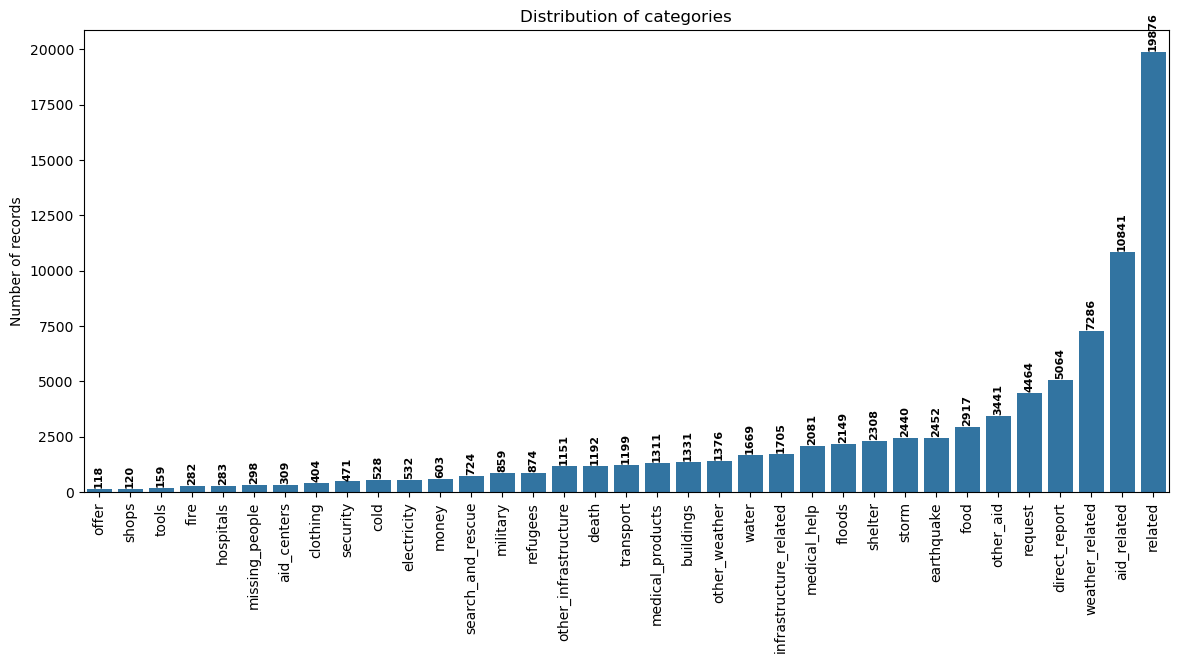

In [8]:
 # plot how categories are distributed
df_sum = df.sum(numeric_only=True).sort_values(ascending=True)
fig = plt.figure(figsize=(14,6))
ax = sns.barplot(data=df_sum)

# annotate
for c in ax.containers:
    # set the bar label based on the y-axis
    ax.bar_label(c, padding=1, fontsize=8, rotation=90, weight='bold')
        
plt.xticks(rotation=90)

plt.title('Distribution of categories')
plt.ylabel('Number of records')
plt.show()

In [9]:
# store the category imbalance sequence
category_sequence = list(df_sum.index)
print(category_sequence)

['offer', 'shops', 'tools', 'fire', 'hospitals', 'missing_people', 'aid_centers', 'clothing', 'security', 'cold', 'electricity', 'money', 'search_and_rescue', 'military', 'refugees', 'other_infrastructure', 'death', 'transport', 'medical_products', 'buildings', 'other_weather', 'water', 'infrastructure_related', 'medical_help', 'floods', 'shelter', 'storm', 'earthquake', 'food', 'other_aid', 'request', 'direct_report', 'weather_related', 'aid_related', 'related']


In [10]:
# store the category imbalance sequence, with total score categories for plotting later on
score_index = category_sequence
for score in list(['micro avg', 'macro avg', 'weighted avg', 'samples avg']):
    category_sequence.append(score)
print(score_index)

['offer', 'shops', 'tools', 'fire', 'hospitals', 'missing_people', 'aid_centers', 'clothing', 'security', 'cold', 'electricity', 'money', 'search_and_rescue', 'military', 'refugees', 'other_infrastructure', 'death', 'transport', 'medical_products', 'buildings', 'other_weather', 'water', 'infrastructure_related', 'medical_help', 'floods', 'shelter', 'storm', 'earthquake', 'food', 'other_aid', 'request', 'direct_report', 'weather_related', 'aid_related', 'related', 'micro avg', 'macro avg', 'weighted avg', 'samples avg']


<a class="anchor" id='step2'></a>
<span style="color:blue; font-size:25px; line-height:30px; font-family: Calibri;">2. Write a tokenization function to process text data</span>

Custom tokenizers was developed — see `utils.py`

In [11]:
# testing tokenizer
test = df[(df['offer'] == 1)]
for message in test['message'][:3]:
    print(message)
    tokens_full = tokenize(message)
    tokens_basic = tokenizer_light(message)
    print(tokens_full)
    print(tokens_basic, '\n')

I am a driver, a mechanic ,. I want to help
['driver', 'mechanic', 'want', 'help']
I am a driver, a mechanic. I want to help 

How can we help the victims at Les Cayes?
['help', 'victims', 'les', 'cayes']
How can we help the victims at Les Cayes? 

I'm the vice president of the association Rafadek in Anse a galets. You can call me so that you could help people in La Gonave
['vice', 'president', 'association', 'rafadek', 'anse', 'galets', 'call', 'could', 'help', 'people', 'la', 'gonave']
I'm the vice president of the association Rafadek in Anse a galets. You can call me so that you could help people in La Gonave 



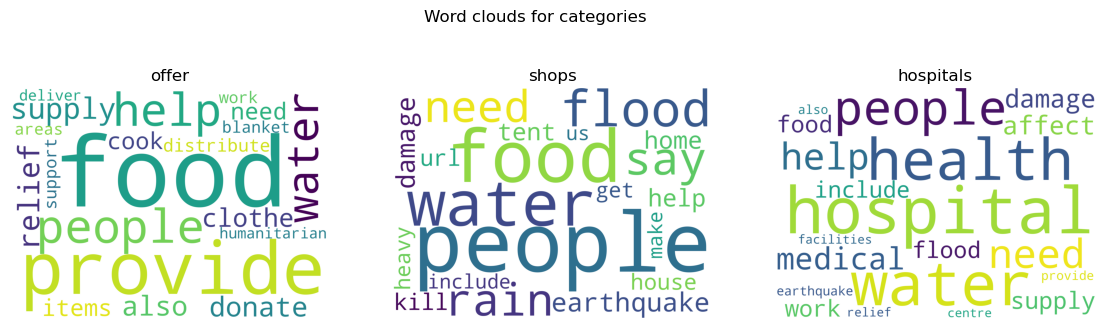

In [12]:
# Print word clouds for up to 3 categories
categories = ['offer', 'shops', 'hospitals']        
cat_word_clouds(categories, df)        

In [13]:
# quick lemmitizer test to take words back to their core
from nltk.corpus import wordnet
words = ['provide', 'provided', 'providing', 'house', 'houses', 'housing', 'cloths', 'clothes']
lemmatizer = WordNetLemmatizer()
print([lemmatizer.lemmatize(word) for word in words] )
print([lemmatizer.lemmatize(word, wordnet.VERB) for word in words])

['provide', 'provided', 'providing', 'house', 'house', 'housing', 'cloth', 'clothes']
['provide', 'provide', 'provide', 'house', 'house', 'house', 'cloths', 'clothe']



<a class="anchor" id='step3'></a>
<span style="color:blue; font-size:25px; line-height:30px; font-family: Calibri;">3. Build a machine learning pipeline</span>

This machine pipeline will take in the `message` and `genre` column as input and output classification results on the other 35 categories in the dataset. 

In [14]:
focal_loss = FocalBinaryLoss(gamma = 10)
fl = make_scorer(focal_loss.focal_binary_cross_entropy)

In [15]:
xgb.set_config(verbosity=2)

# cache transformers, so they are only executed once, especially during gridsearch

cachedir = '../cache'

# using defaults of XGBOOST
params = {
    'objective': 'binary:logitraw',
    'n_jobs': -1,
    'max_depth': 8,
    'min_child_weight': 1.4,
    'gamma': 0.6,
    'eval_metric': fl,
    'booster': 'gbtree',   
    'n_estimators': 100,
    'colsample_bytree': 1, # default is 1,
    'subsample': 1, # default is 1
    'tree_method': 'hist', # exact, approx, auto, hist
    'scale_pos_weight': 1,
    'max_delta_step': 15, # default is None
    'reg_lambda': 0.004, # lambda
    'reg_alpha': 0.003, # alpha
    'learning_rate': 0.4,
    'verbosity': 2,
    'random_state' : random_state,
    # one_hot_encoding support is not compatible with column transformer which return an array
    # 'enable_categorical': True,
    # 'max_cat_to_onehot': 5,
    'multi_strategy':'one_output_per_tree',  
}

text_nlp = Pipeline(steps=[
    ('vect', CountVectorizer(tokenizer=tokenize, 
                             token_pattern=None,
                             min_df=3,   # if a word appears in less than 3 documents, ignore it
                             max_df=0.95, # remove too frequent words in 90% of documents
                             max_features=10000,
                             ngram_range=(1,2))),    
    ('tfidf', TfidfTransformer(sublinear_tf=False)),    
    ],
    verbose=False)

# preprocessor for NLP
preprocessor = ColumnTransformer(transformers=[
    ('text_vect', text_nlp, 'message'),
    ('one_hot', OneHotEncoder(), ['genre']),    
],
    verbose_feature_names_out=False,
    remainder='drop',
    verbose=True,
)

pipeline_base = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb.XGBClassifier(**params)),    
],
    memory=cachedir,
    verbose=True,
)

<a class="anchor" id='step4'></a>
<span style="color:blue; font-size:25px; line-height:30px; font-family: Calibri;">4. Set a baseline - Train pipeline and evaluate model</span>

- Split data into train, validation and test datasets, using a custom function that use 'MultilabelStratifiedKFold'
- Oversample the minority classes
- Set a baseline - Train pipeline and evaluate the model
    
**Note**: it is not possible to use multioutput and xgboost with callbacks or early stop for multi label, it is not supported if in a pipeline.

#### Split data into train, validation and test datasets

In [16]:
# features for modelling
X = df[['message', 'genre']].copy(deep=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26179 entries, 2 to 30265
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   message  26179 non-null  object  
 1   genre    26179 non-null  category
dtypes: category(1), object(1)
memory usage: 434.7+ KB


In [17]:
# extract labels
y = df.loc[:, category_names].copy()
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26179 entries, 2 to 30265
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   related                 26179 non-null  int8 
 1   request                 26179 non-null  int8 
 2   offer                   26179 non-null  int8 
 3   aid_related             26179 non-null  int8 
 4   medical_help            26179 non-null  int8 
 5   medical_products        26179 non-null  int8 
 6   search_and_rescue       26179 non-null  int8 
 7   security                26179 non-null  int8 
 8   military                26179 non-null  int8 
 9   water                   26179 non-null  int8 
 10  food                    26179 non-null  int8 
 11  shelter                 26179 non-null  int8 
 12  clothing                26179 non-null  int8 
 13  money                   26179 non-null  int8 
 14  missing_people          26179 non-null  int8 
 15  refugees                

In [18]:
# split data into test, validation, and test datasets, whilst using stratification to handle imbalance
X_train, y_train, X_val, y_val, X_test, y_test = custom_test_val_train_split(X, y, random_state=random_state)

Total records: X(26179, 2):y(26179, 35)
Train shape: X(17452, 2):y(17452, 35)
Validation shape: X(4363, 2):y(4363, 35)
Test shape: X(4364, 2):y(4364, 35)


In [19]:
# make sure data type 'category' is kept
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17452 entries, 2 to 30262
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   message  17452 non-null  object  
 1   genre    17452 non-null  category
dtypes: category(1), object(1)
memory usage: 289.9+ KB


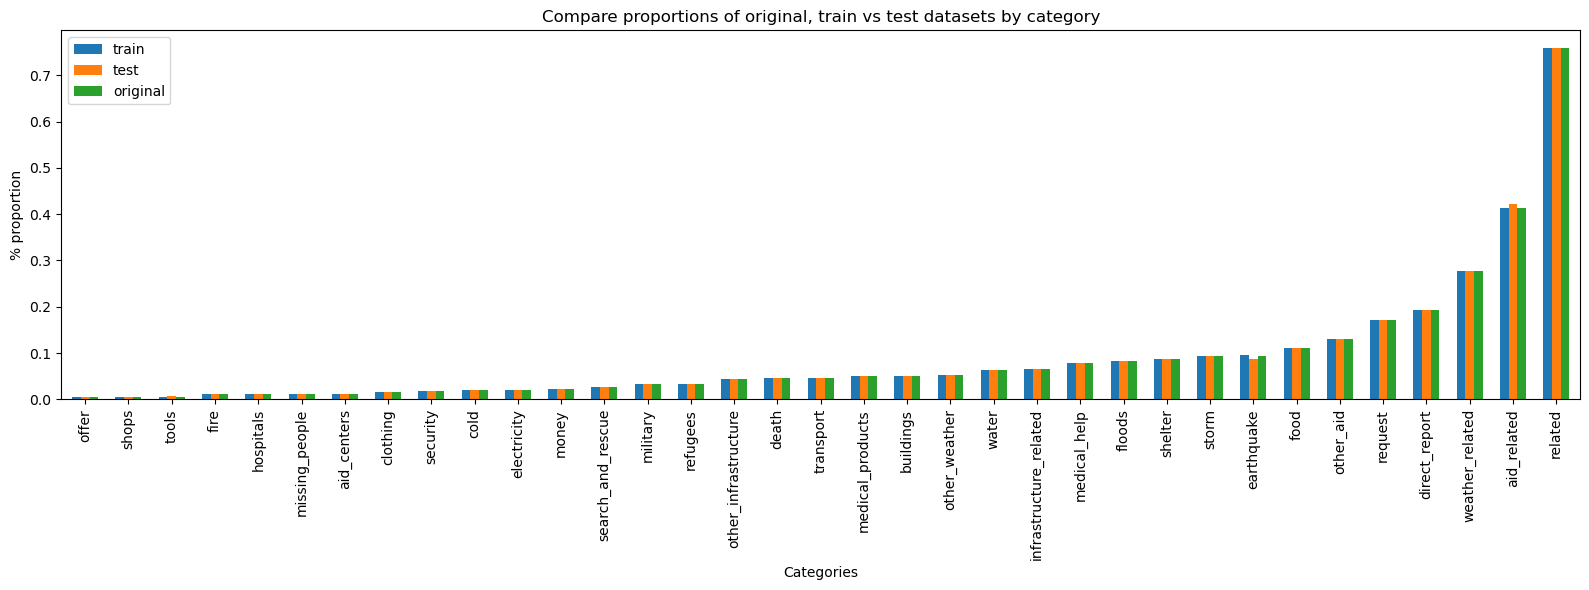

In [20]:
# make sure proportions are the same for original y, test and train datasets due to stratified split
plot_label_proportions(y, y_train, y_test)

>###### Label were split in the same proportions between train, validation and test datasets

#### Oversample the minority classes

A new class was build with two options:
- MLOverSampling.minority_oversampling will duplicate records of minority classes
- MLOverSampling.augment_text will create new records by augmentation to replace some words with synonyms

Data Augmentation will be used for this model

In [21]:
# Oversample the minority classes (simply duplicate lines)
# ml_sampler = MLOverSampling()
# print('Training shapes before: {} {}'.format(X_train.shape, y_train.shape)) 
# X_train_sub, y_train_sub, imbalanced_labels = ml_sampler.minority_oversampling(X_train, y_train)
# print('Training shapes after: {} {}'.format(X_train_sub.shape, y_train_sub.shape))    

# Augment the minority classes (generate new sentences by replacing some words with synonyms)
ml_sampler = MLOverSampling()
print('Training shapes before: {} {}'.format(X_train.shape, y_train.shape)) 
X_train_sub, y_train_sub, imbalanced_labels = ml_sampler.augment_text(X_train, y_train)
print('Training shapes after: {} {}'.format(X_train_sub.shape, y_train_sub.shape)) 

Training shapes before: (17452, 2) (17452, 35)
Imbalanced labels: ['offer', 'security', 'clothing', 'missing_people', 'tools', 'hospitals', 'shops', 'aid_centers', 'fire']
Minority samples: (1395, 2) (1395, 35)
Training shapes after: (30815, 2) (30815, 35)


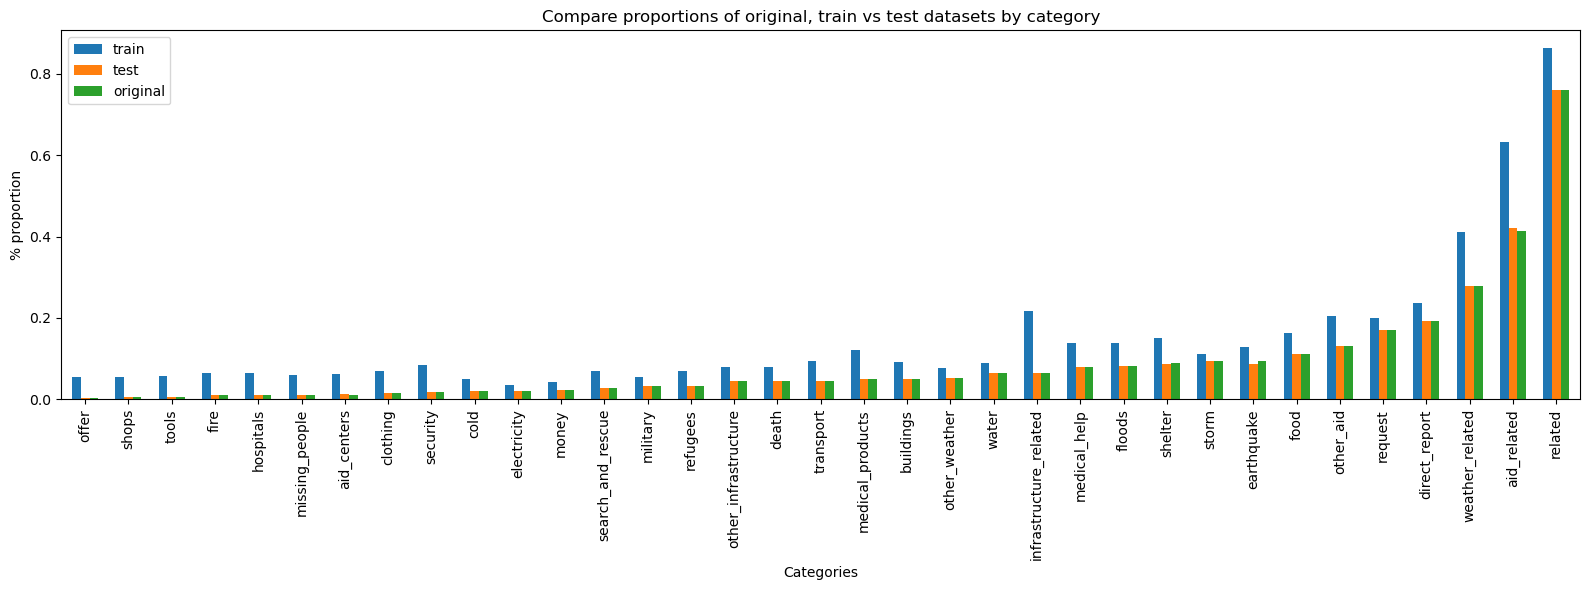

In [22]:
plot_label_proportions(y, y_train_sub, y_test)

> Minority classes on the left now have an increased proportion

#### Train pipeline

In [23]:
# label_ratio = ml_sampler.get_sample_ratio(y_train_sub)
# sample_weights = calculate_sample_weights(label_ratio, y_train, power=1)
# pipeline_base.fit(X_train_sub, y_train_sub, clf__sample_weight=sample_weights)
pipeline_base.fit(X_train_sub, y_train_sub)
rmtree(cachedir)

[ColumnTransformer] ..... (1 of 2) Processing text_vect, total= 1.9min
[ColumnTransformer] ....... (2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 1.9min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 6.7min


#### Evaluate the model



In [24]:
# Evaluate results
y_pred_val, score_base = evaluate(X_val, y_val, pipeline_base, zero_division=0)
auc_base = print_results(y_val, y_pred_val)

                        precision    recall  f1-score   support

               related       0.85      0.91      0.88      3313
               request       0.75      0.53      0.62       744
                 offer       0.00      0.00      0.00        20
           aid_related       0.72      0.61      0.66      1801
          medical_help       0.54      0.22      0.31       347
      medical_products       0.56      0.30      0.39       219
     search_and_rescue       0.50      0.12      0.20       121
              security       0.17      0.05      0.08        79
              military       0.58      0.26      0.36       144
                 water       0.78      0.58      0.66       278
                  food       0.79      0.72      0.75       486
               shelter       0.77      0.55      0.64       385
              clothing       0.57      0.51      0.54        68
                 money       0.49      0.28      0.36       100
        missing_people       0.35      

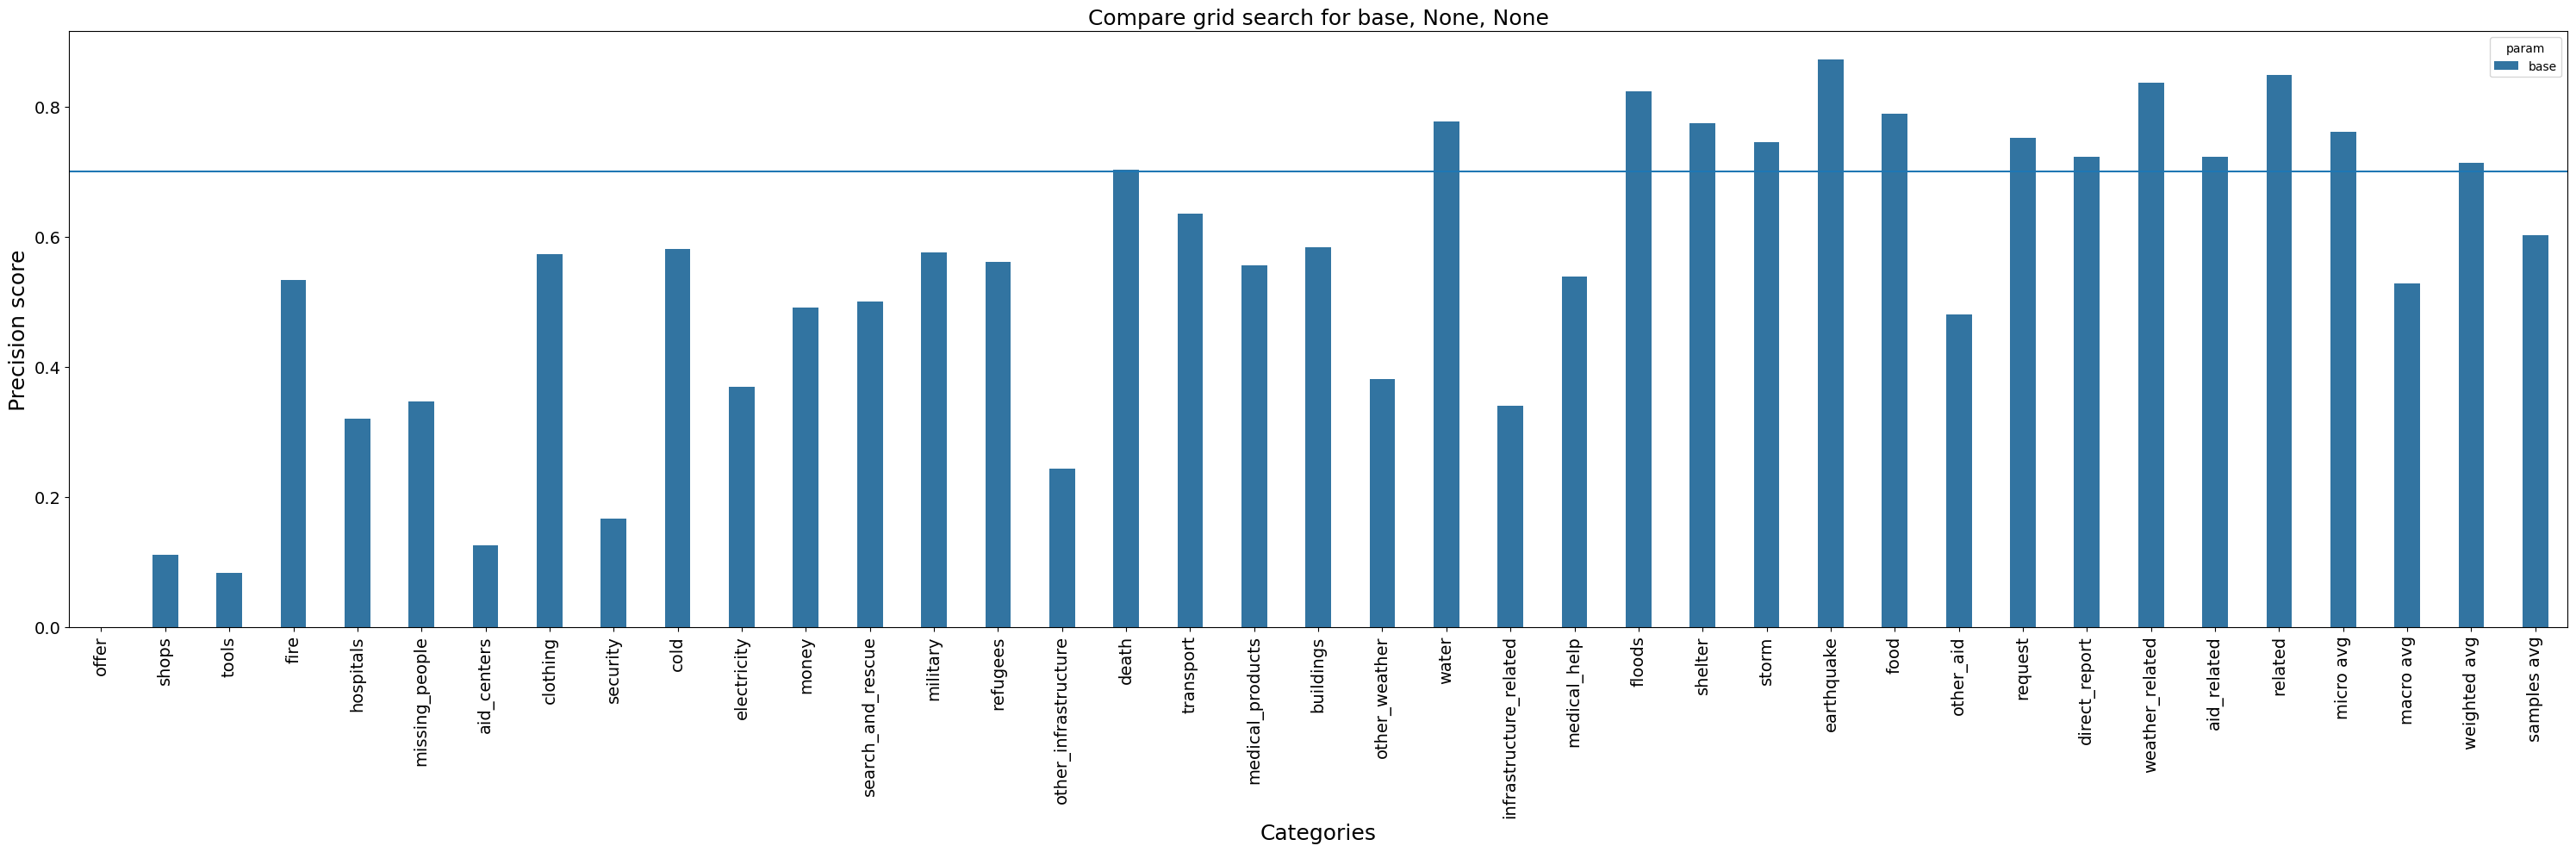

In [25]:
# Update model parameters with cross-validation results
plot_scores(score1=score_base, score2=None, score3=None, score1_name='base', score2_name=None, score3_name=None, order=score_index)


<a class="anchor" id='step5'></a>
<span style="color:blue; font-size:25px; line-height:40px; font-family: Calibri;">5. Improve the model with GridSearch</span>

Use grid search to find better parameters. 

As **GridSearchCV** usage is a project requirement, demonstrate it's usage by choosing sample ratios to avoid overfitting.

As a second step, [OPTUNA](https://www.dailydoseofds.com/bayesian-optimization-for-hyperparameter-tuning/) will be used for further hyperparameter tuning, as it's much faster.

Both Grid search and Random Search evaluate every hyperparameter configuration independently. Thus, they iteratively explore all hyperparameter configurations to find the most optimal one.

However, Bayesian Optimization takes informed steps based on the results of the previous hyperparameter configurations.

This lets it confidently discard non-optimal configurations. Consequently, the model converges to an optimal set of hyperparameters much faster.

**Precision score** is used as the main metrics, as we don't want to waste resources during a crises. We want to send food and ambulances where we are sure it's needed.

**Macro-average** was selected, to give equal importance by class, to handle class imbalance.
Macro-average will group sample by class and aggregate (using the mean) afterward. Therefore, you increase the importance of data points from under-represented classes because you consider them as important of highly populated classes.

[Click here to see XGBOOST documentation how to handle Imbalance](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#handle-imbalanced-dataset)

#### 5.1 - Tune `max_depth` and `n_estimators` to control overfitting




In [26]:
verbose = 1
scoring = make_scorer(precision_score, average='macro', zero_division=0)

In [27]:
hyperparameters = {
    "clf__max_depth": [6, 8, 12],
    "clf__n_estimators": [50, 100],
}

gridsearch1 = cv_predefined(X_train=X_train_sub,
                            y_train=y_train_sub,
                            X_val=X_val,
                            y_val=y_val,
                            pipeline=pipeline_base,
                            hyperparameters=hyperparameters,
                            scoring=scoring,
                            verbose=verbose,
                            random_state=random_state,
                            nr_splits=3)

rmtree(cachedir)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[ColumnTransformer] ..... (1 of 2) Processing text_vect, total= 1.3min
[ColumnTransformer] ....... (2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.6min
[ColumnTransformer] ..... (1 of 2) Processing text_vect, total= 1.3min
[ColumnTransformer] ....... (2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.7min
[ColumnTransformer] ..... (1 of 2) Processing text_vect, total= 1.3min
[ColumnTransformer] ....... (2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 1.3min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.7min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 4.6min
[Pipeline] ......

In [28]:
# Update model parameters with cross-validation results
pipeline_base.set_params(**gridsearch1.best_params_)
pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val, score_gridsearch = evaluate(X_val, y_val, pipeline_base)
auc_gridsearch = print_results(y_val, y_pred_val)

[ColumnTransformer] ..... (1 of 2) Processing text_vect, total= 2.0min
[ColumnTransformer] ....... (2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.0min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 9.9min
                        precision    recall  f1-score   support

               related       0.87      0.90      0.88      3313
               request       0.76      0.53      0.63       744
                 offer       0.17      0.05      0.08        20
           aid_related       0.72      0.62      0.67      1801
          medical_help       0.55      0.27      0.36       347
      medical_products       0.58      0.27      0.37       219
     search_and_rescue       0.45      0.12      0.19       121
              security       0.16      0.04      0.06        79
              military       0.65      0.26      0.37       144
                 water       0.74      0.59      0.66       278
           

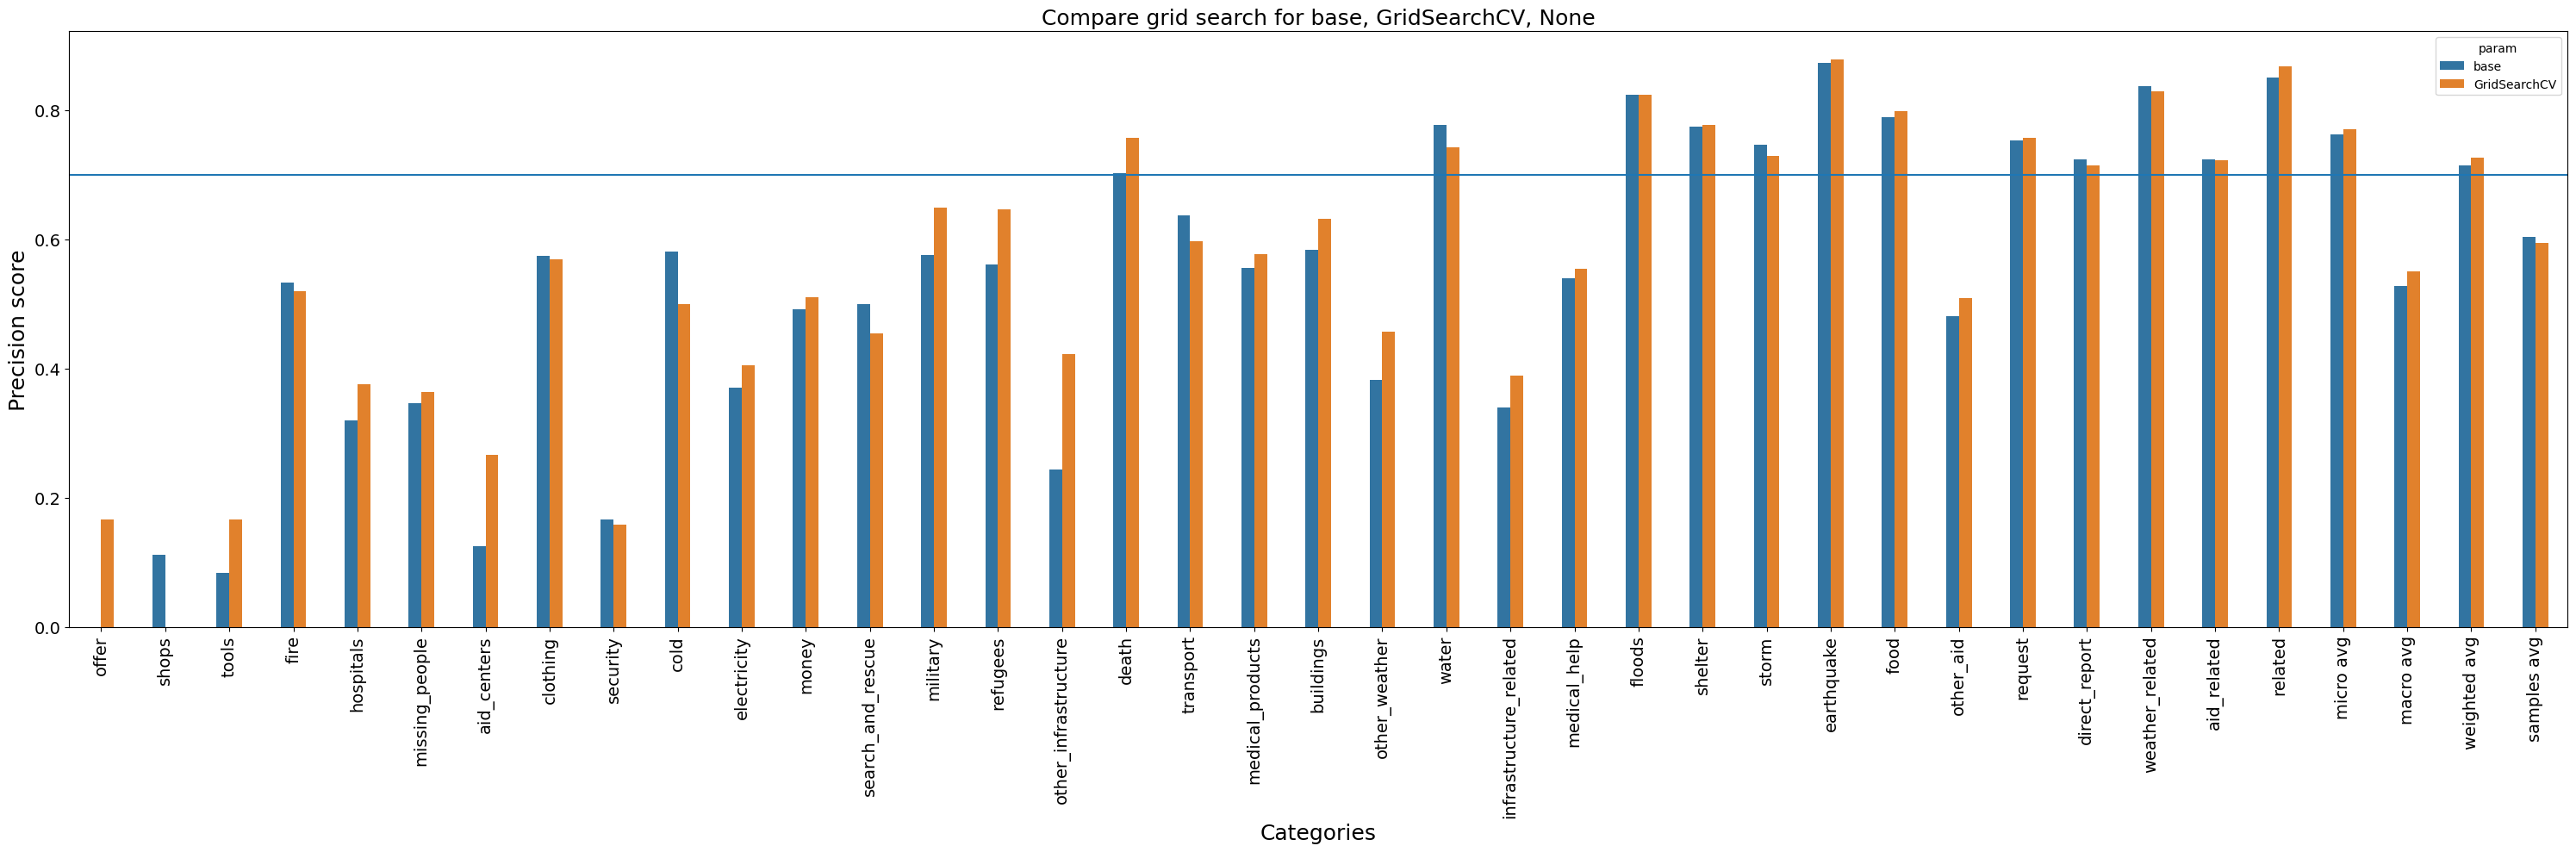

In [29]:
plot_scores(score1=score_base, score2=score_gridsearch, score3=None, score1_name='base', score2_name='GridSearchCV', score3_name=None, order=score_index)

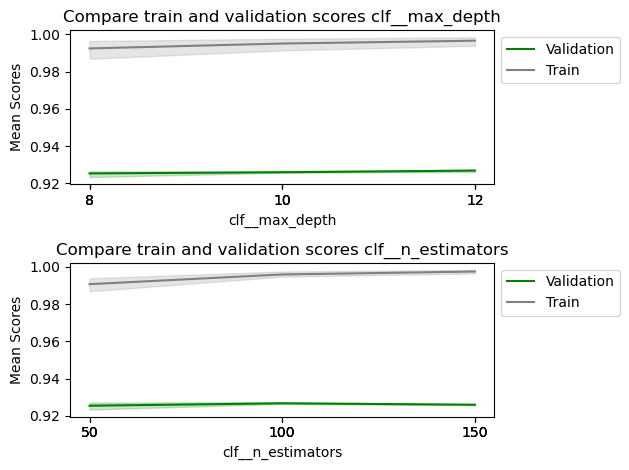

In [30]:
cv_plot_scores(gridsearch1)

In [31]:
print('Base AUC = {}, grid search AUC = {}'.format(auc_base, auc_gridsearch))

Base AUC = 0.648136057039661, grid search AUC = 0.6522495420041835


#### 5.2 - Use OPTUNA for faster grid search for more parameters

In [32]:
## Try Bayes_Optimzation
def objective(trial):    
    """ Grid search using Optuna """
    param = {         
        'clf__max_delta_step': trial.suggest_float('clf__max_delta_step', low=0, high=100),             
        'clf__max_depth': trial.suggest_int('clf__max_depth', low=2, high=12, step=1),
        'clf__reg_lambda': trial.suggest_float('clf__reg_lambda', low=0.0001, high=40), 
        'clf__gamma': trial.suggest_float('clf__gamma', low=0.0001, high=50),
        'clf__min_child_weight': trial.suggest_float('clf__min_child_weight', low=1, high=50),     
        'clf__reg_alpha': trial.suggest_float('clf__reg_alpha', low=0.0001, high=40),  
        'clf__learning_rate': trial.suggest_float('clf__learning_rate', low=0.0001, high=10, log=True),
        'clf__grow_policy': trial.suggest_categorical("clf__grow_policy", ["depthwise", "lossguide"])
    }

    pipeline_base.set_params(**param)
    
    score = cross_val_score(estimator=pipeline_base,
                             X=X_train_sub, 
                             y=y_train_sub, 
                             scoring=scoring,
                             cv=MultilabelStratifiedKFold(n_splits=2,
                                                           shuffle=True,
                                                           random_state=random_state),
                            ).mean()
    
    return score

# clear the garbage to free memory
gc.collect()

# Unique identifier of the study
study_name = "xgboost-study1"  

# save study to SQLite database
storage_name =config.path_database_optuna

# Propagate logs to the root logger
optuna.logging.enable_propagation()  

# Stop showing logs in sys.stderr
optuna.logging.disable_default_handler()

# Continue grid searching on existing study if it exists (same db and name)
study = optuna.create_study(sampler=TPESampler(), direction="maximize", study_name=study_name, storage=storage_name, load_if_exists=True )

logger.info("START OPTUNA OPTIMIZATION...")
study.optimize(objective, n_trials=30)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

rmtree(cachedir)

[ColumnTransformer] ..... (1 of 2) Processing text_vect, total=  59.0s
[ColumnTransformer] ....... (2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  59.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.5min
[ColumnTransformer] ..... (1 of 2) Processing text_vect, total=  57.7s
[ColumnTransformer] ....... (2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=  57.7s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.5min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.8min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 1.7min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.6min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.6min
[Pipeline] ............... (step 2 of 2) Processing clf, total=  49.3s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  47.3s
[Pipel

In [33]:
print(f"---Bayesian Optimization---")
print(f"Number of iterations: {len(study.trials)}")
print(f"Best trial index: {study.best_trial.number}")
print(f"Best score: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_params}")

---Bayesian Optimization---
Number of iterations: 462
Best trial index: 159
Best score: 0.9358661138082169
Best hyperparameters: {'clf__max_delta_step': 40.23331277707074, 'clf__max_depth': 11, 'clf__reg_lambda': 0.019710998210811237, 'clf__gamma': 25.047678170913976, 'clf__min_child_weight': 2.2956319404678, 'clf__reg_alpha': 1.834436046249881, 'clf__learning_rate': 0.0372265279270068, 'clf__grow_policy': 'lossguide'}


In [34]:
# load study results into a dataframe
optuna_study = study.trials_dataframe()
optuna_study.head()

,number,value,datetime_start,datetime_complete,duration,params_clf__gamma,params_clf__grow_policy,params_clf__learning_rate,params_clf__max_delta_step,params_clf__max_depth,params_clf__min_child_weight,params_clf__reg_alpha,params_clf__reg_lambda,state
0,0,0.641197059210350195357364100345876067876815795898437500,2024-09-16 23:40:44.947875,2024-09-16 23:45:34.000186,0 days 00:04:49.052311,34.224597843421527443297236459329724311828613281250,depthwise,0.5926803180751558652872290622326545417308807373046875000000,14.592736422565732112843761569820344448089599609375,2,38.9910195103666197269376425538212060928344726562500,5.12699130717992002104210769175551831722259521484375,16.710770919616891205805586650967597961425781250000,COMPLETE
1,1,0.227012175572470498163824004222988151013851165771484375,2024-09-16 23:45:34.026193,2024-09-16 23:48:40.758092,0 days 00:03:06.731899,42.335211544290991980687977047637104988098144531250,lossguide,9.9488067753424314076937662321142852306365966796875000000000,76.261847882425982447784917894750833511352539062500,10,6.9214245682611927890093284077011048793792724609375,16.32976311895370358229229168500751256942749023437500,16.626244855571506775504531105980277061462402343750,COMPLETE
2,2,0.494928872778903572449138437150395475327968597412109375,2024-09-16 23:48:40.779950,2024-09-16 23:51:30.704368,0 days 00:02:49.924418,34.320609658988402657087135594338178634643554687500,lossguide,8.2697323708909937778344101388938724994659423828125000000000,17.510360352427024821508894092403352260589599609375,2,23.1104070741239659980692522367462515830993652343750,4.77330291297864128807759698247537016868591308593750,2.052228921455938603912727558054029941558837890625,COMPLETE
3,3,0.561721760927122337747618985304143279790878295898437500,2024-09-16 23:51:30.725345,2024-09-16 23:54:30.759928,0 days 00:03:00.034583,19.975407984335991073976401821710169315338134765625,lossguide,0.1818427813132979797838828517342335544526576995849609375000,93.209706420290444839338306337594985961914062500000,2,36.0532046716371681327473197598010301589965820312500,29.66420264004590379158798896241933107376098632812500,20.157874906410246040877609630115330219268798828125,COMPLETE
4,4,0.722460820332273656596555611031362786889076232910156250,2024-09-16 23:54:30.780774,2024-09-16 23:59:12.814192,0 days 00:04:42.033418,27.698100572601802582539676222950220108032226562500,depthwise,0.0284651500484887666486688573286301107145845890045166015625,58.511931035252970900728541892021894454956054687500,9,20.4426905217078456189483404159545898437500000000000,6.57990980187102714182856288971379399299621582031250,13.046771342297304840940341819077730178833007812500,COMPLETE


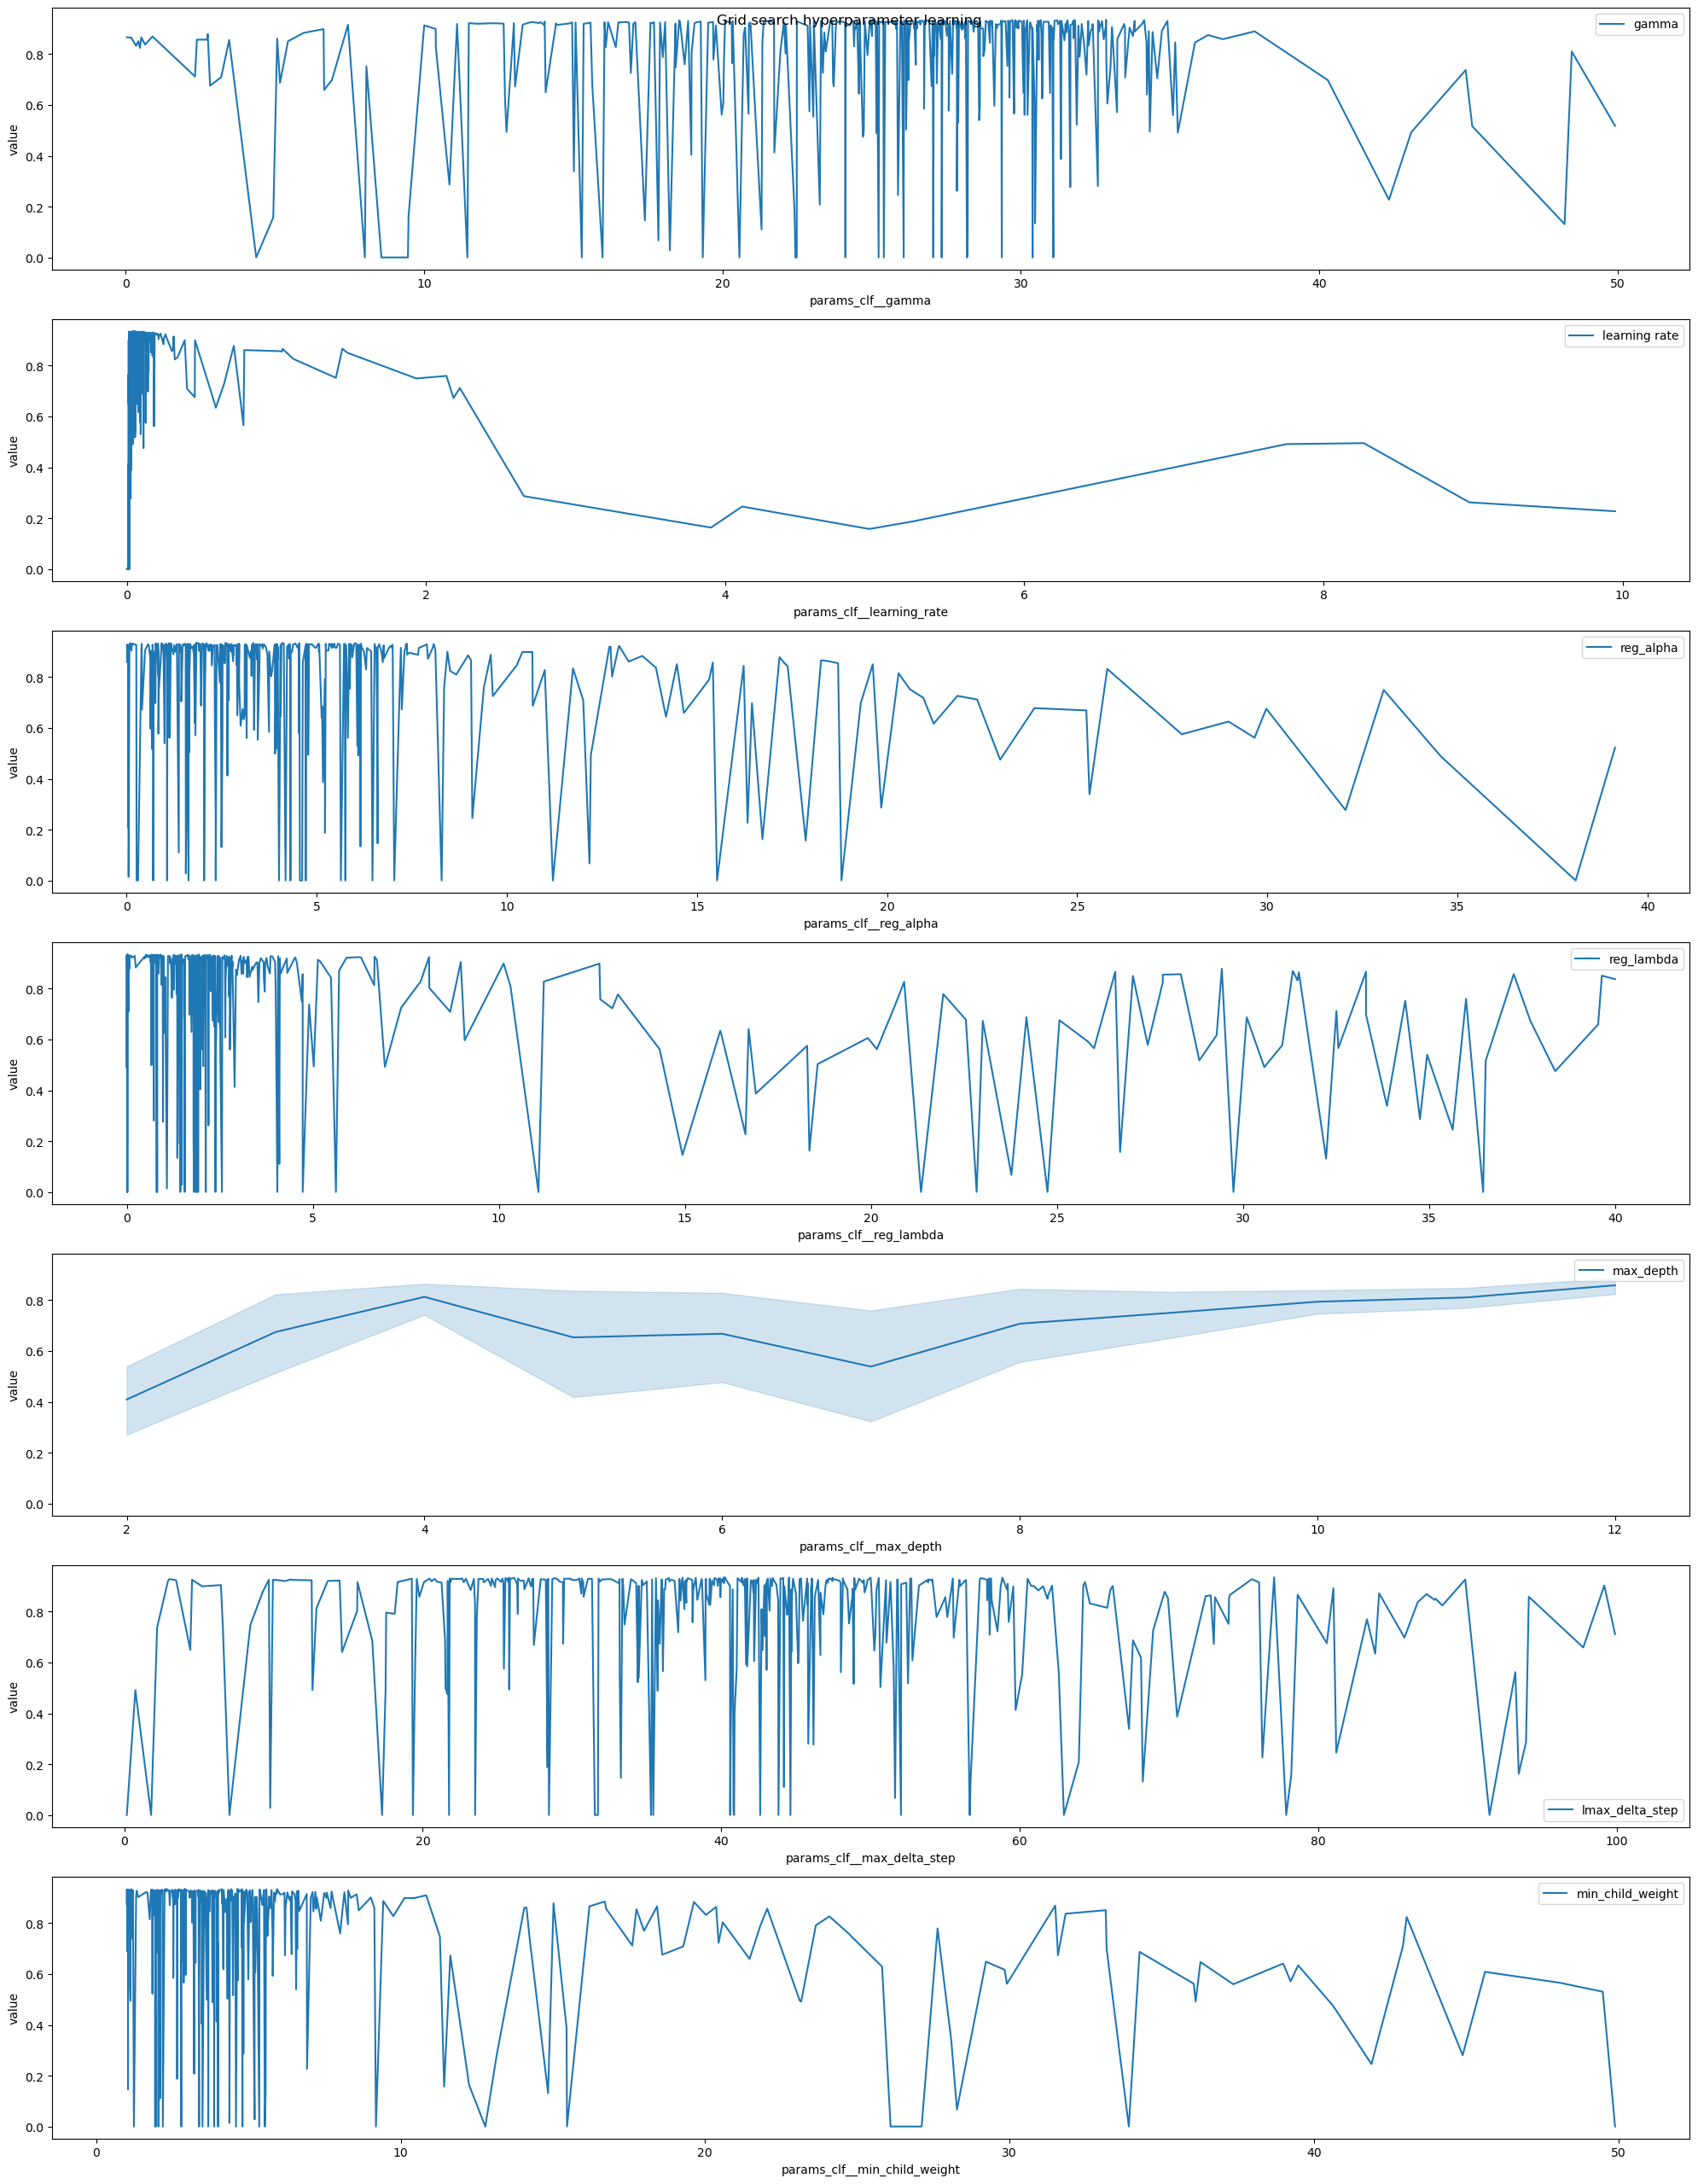

In [35]:
# plot performance of learning rate and gamma
fig, ax = plt.subplots(7, sharey=True, figsize=(20,26))
sns.lineplot(data=optuna_study, x='params_clf__gamma', y='value', label='gamma', ax=ax[0])
sns.lineplot(data=optuna_study, x='params_clf__learning_rate', y='value', label='learning rate', ax=ax[1])
sns.lineplot(data=optuna_study, x='params_clf__reg_alpha', y='value', label='reg_alpha', ax=ax[2])
sns.lineplot(data=optuna_study, x='params_clf__reg_lambda', y='value', label='reg_lambda', ax=ax[3])
sns.lineplot(data=optuna_study, x='params_clf__max_depth', y='value', label='max_depth', ax=ax[4])
sns.lineplot(data=optuna_study, x='params_clf__max_delta_step', y='value', label='lmax_delta_step', ax=ax[5])
sns.lineplot(data=optuna_study, x='params_clf__min_child_weight', y='value', label='min_child_weight', ax=ax[6])
plt.suptitle('Grid search hyperparameter learning')
plt.tight_layout()

In [36]:
# Save the sampler with pickle to be reused later.
# with open(config.path_model_optuna_study, "wb") as fout:
#     dump(study.sampler, fout)
    
with open(config.path_model_optuna_study, "wb") as fout:
    dump(study.sampler, fout)

In [37]:
pipeline_base.set_params(**study.best_params)

# make sure parameters are set correctly
pipeline_base.get_params()

# best results so far, it's looking great, macro is 60 !!
# Best hyperparameters: {'clf__max_delta_step': 40.23331277707074, 'clf__max_depth': 11, 'clf__reg_lambda': 0.019710998210811237, 'clf__gamma': 25.047678170913976, 'clf__min_child_weight': 2.2956319404678, 'clf__reg_alpha': 1.834436046249881, 'clf__learning_rate': 0.0372265279270068, 'clf__grow_policy': 'lossguide'}


{'memory': '../cache',
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('text_vect',
                                    Pipeline(steps=[('vect',
                                                     CountVectorizer(max_df=0.95,
                                                                     max_features=10000,
                                                                     min_df=3,
                                                                     ngram_range=(1,
                                                                                  2),
                                                                     token_pattern=None,
                                                                     tokenizer=<function tokenize at 0x7ffce4f0e820>)),
                                                    ('tfidf',
                                                     TfidfTransformer())]),
                                    'message'),
                       

In [38]:
# clear the garbage to free memory
gc.collect()

# param_update = {
#     'clf__max_delta_step': 15,
# #     'clf__max_depth': 8,
# #     'clf__reg_lambda': 0.3195544713510632,
#     'clf__gamma': 0.6,
#     # 'clf__min_child_weight': 1.4
# #     'clf__reg_alpha': 10.219565212950162,
# #     'clf__learning_rate': 0.18474971429526232,
#     'clf__grow_policy': 'lossguide', #depthwise
# }
# 
# pipeline_base.set_params(**param_update)

pipeline_base.fit(X_train_sub, y_train_sub)
y_pred_val, score_optuna = evaluate(X_val, y_val, pipeline_base)
auc_optuna = print_results(y_val, y_pred_val)
rmtree(cachedir)

[ColumnTransformer] ..... (1 of 2) Processing text_vect, total= 2.0min
[ColumnTransformer] ....... (2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.0min
[Pipeline] ............... (step 2 of 2) Processing clf, total= 9.2min
                        precision    recall  f1-score   support

               related       0.81      0.95      0.88      3313
               request       0.80      0.47      0.59       744
                 offer       0.00      0.00      0.00        20
           aid_related       0.73      0.58      0.65      1801
          medical_help       0.66      0.10      0.17       347
      medical_products       0.63      0.24      0.35       219
     search_and_rescue       0.67      0.07      0.12       121
              security       0.25      0.01      0.02        79
              military       0.78      0.12      0.22       144
                 water       0.78      0.54      0.64       278
           

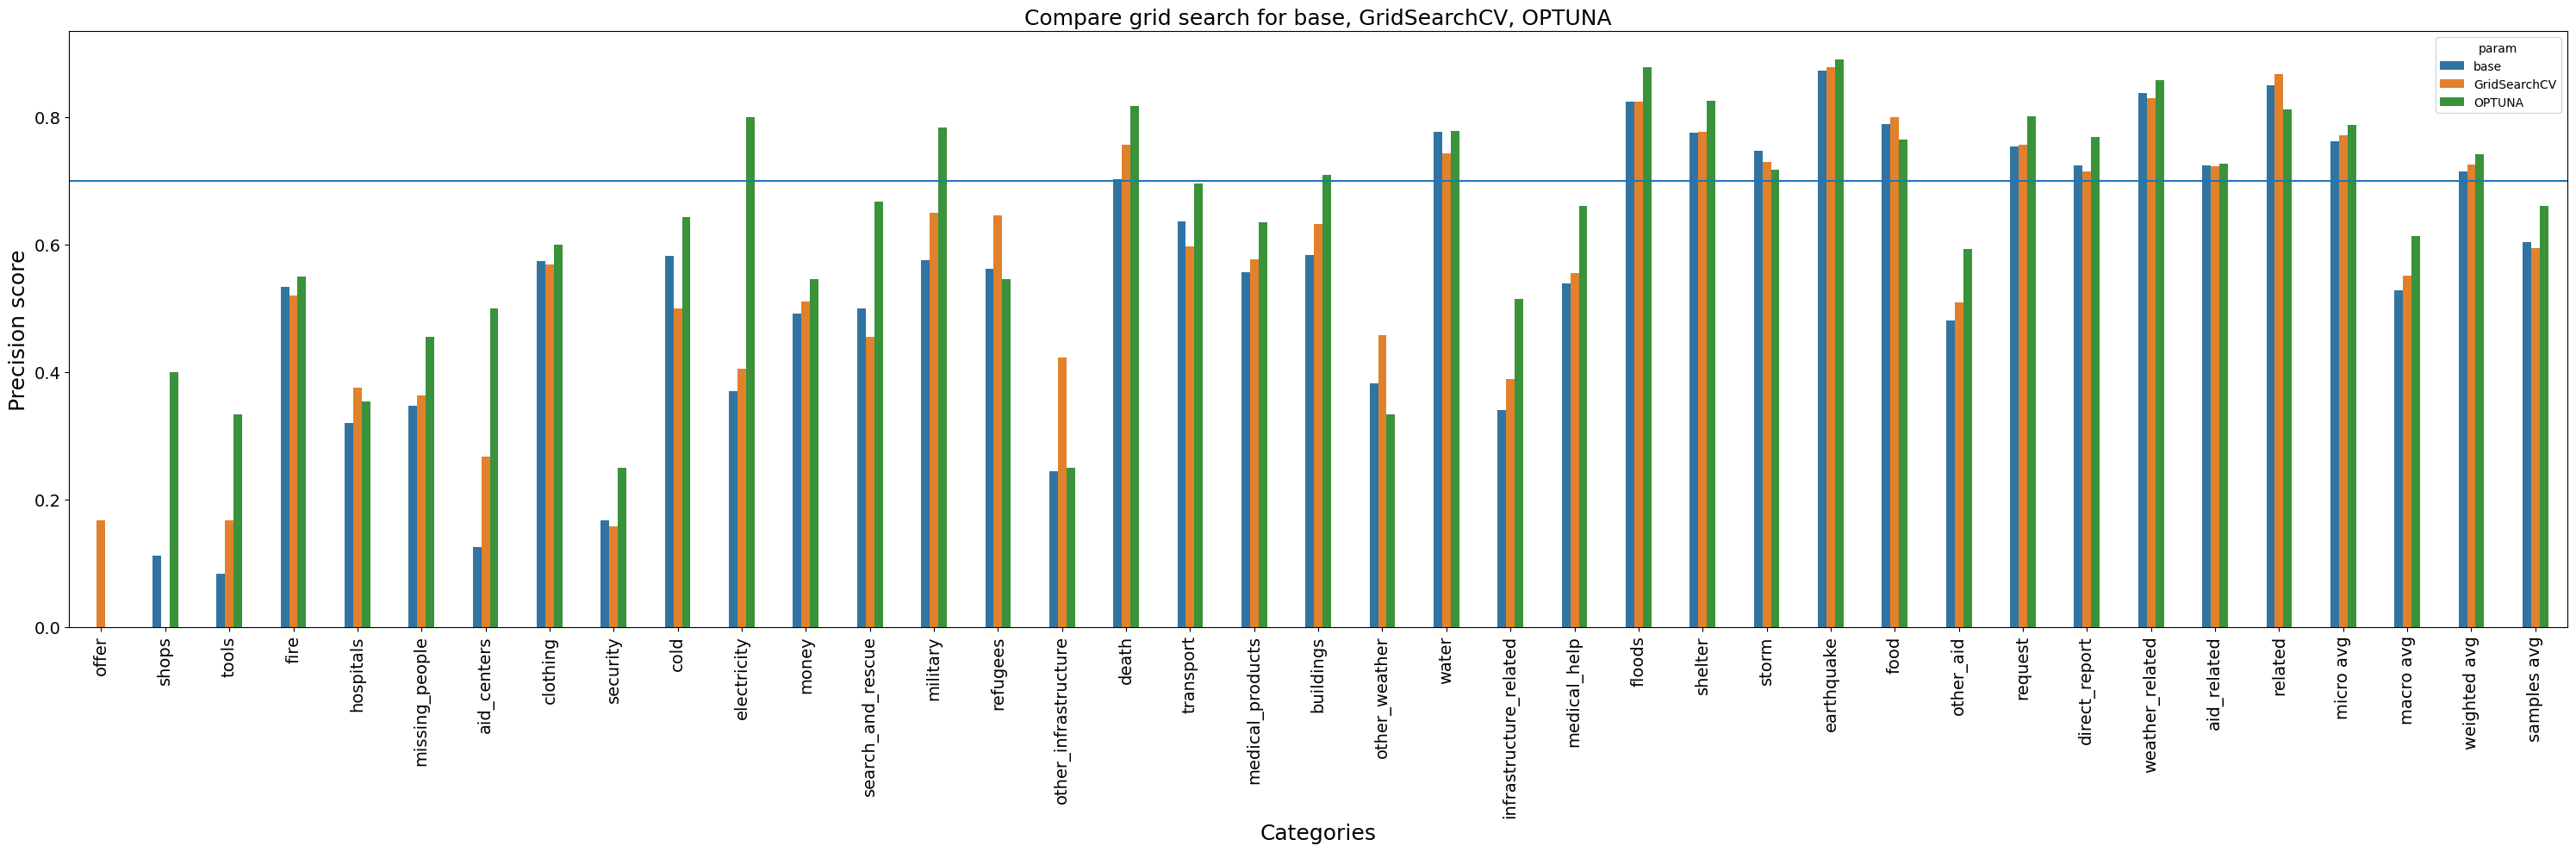

In [39]:
# Update model parameters with cross-validation results
plot_scores(score1=score_base, score2=score_gridsearch, score3=score_optuna, score1_name='base', score2_name='GridSearchCV', score3_name='OPTUNA', order=score_index)

<a class="anchor" id='step6'></a>
<span style="color:blue; font-size:25px; line-height:40px; font-family: Calibri;">6. Try improving your model further</span>

* Try out XGBOOST `multi_output_tree`, a new feature for solving multi-label problems
* Add `starting_verb` feature
* Try to use embeddings from OpenAI to see if context is better understood

In [40]:
# update parameters with grid search results
# param_new = pipeline_base['clf'].get_params()
# param_new
# for key, value in gridsearch1.best_params_.items():
#     param_new[key[5:]] = value
# 
# param_new['max_delta_step'] = 67.26523269884208
# param_new['max_delta_step'] = 67.26523269884208
# param_new['reg_lambda'] = 0.023568710672415415
# param_new['gamma'] = 0.22741071595764697
# param_new['min_child_weight'] = 1.0963419290100873
# param_new['reg_alpha'] = 0.0018542396721656024
# param_new['learning_rate'] = 0.07767686584377648
# param_new['grow_policy'] = 'lossguide'
#     
# param_new

<a class="anchor" id='step61'></a>
<span style="color:blue; font-size:20px; line-height:40px; font-family: Calibri;">6.1 Try XGBOOST 'multi_output_tree'</span>

In [41]:
# clear the garbage and cache to free memory
gc.collect()

params_multi_tree = {
    'clf__multi_strategy': 'multi_output_tree',
}

pipeline_base.set_params(**params_multi_tree)

# make sure pipeline_base has the correct parameters
pipeline_base['clf'].get_params()

{'objective': 'binary:logitraw',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': make_scorer(focal_binary_cross_entropy, response_method='predict'),
 'feature_types': None,
 'gamma': 25.047678170913976,
 'grow_policy': 'lossguide',
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.0372265279270068,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': 40.23331277707074,
 'max_depth': 11,
 'max_leaves': None,
 'min_child_weight': 2.2956319404678,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': 'multi_output_tree',
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 10,
 'reg_alpha': 1.834436046249881,
 'reg_lambda': 0.019710998210811237,
 'sampling_method': None,
 'scale_pos_weight': 1

In [ ]:
pipeline_base.fit(X_train_sub, y_train_sub)
rmtree(cachedir)

[ColumnTransformer] ..... (1 of 2) Processing text_vect, total= 2.0min
[ColumnTransformer] ....... (2 of 2) Processing one_hot, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total= 2.0min


In [ ]:
y_pred_val, score_multi_tree = evaluate(X_val, y_val, pipeline_base)
auc_multi_tree = print_results(y_val, y_pred_val)

In [ ]:
plot_scores(score1=score_base, score2=score_optuna, score3=score_multi_tree, score1_name='base', score2_name='OPTUNA', score3_name='multi_output_tree', order=score_index)

>Observation: `multi_output_tree` is performing worse than `one_output_per_tree` at the moment, lets revert back

In [ ]:
# multi output trees does not seem to perform better, let's set it back to `one_output_per_tree`
params_multi_tree = {
    'clf__multi_strategy': 'one_output_per_tree',
}

pipeline_base.set_params(**params_multi_tree)

# make sure pipeline_base has the correct parameters
pipeline_base['clf'].get_params()

<a class="anchor" id='step62'></a>
<span style="color:blue; font-size:20px; line-height:40px; font-family: Calibri;">6.2 Add new feature 'starting_verb'</span>

In [ ]:
# clear the garbage and cache to free memory
gc.collect()

# cache transformers, so they are only executed once, especially during gridsearch
cachedir = '../cache'

# update parameters with grid search results
params_new = pipeline_base['clf'].get_params()

# preprocessor for NLP
text_nlp = Pipeline(steps=[
    ('vect', CountVectorizer(tokenizer=tokenize, 
                             token_pattern=None,
                             min_df=3,   # if a word appears in less than 3 documents, ignore it
                             max_df=0.95, # remove too frequent words  
                             max_features=9000,
                             ngram_range=(1,2))),    
    ('tfidf', TfidfTransformer(sublinear_tf=False)),    
    ],
    verbose=False)

preprocessor = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(), ['genre']), 
    ('starting_verb', StartingVerbExtractor(), ['message']),    
    ('text_vect', text_nlp, 'message'),
    
],
    verbose_feature_names_out=False,
    remainder='drop',
    verbose=True,
)

pipeline_starting_verb = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb.XGBClassifier(**params_new)),    
],
    memory=cachedir,
    verbose=True,
)

In [ ]:
# train classifier
pipeline_starting_verb.fit(X_train_sub, y_train_sub)
rmtree(cachedir)

In [ ]:
y_pred_val,  score_verb = evaluate(X_val, y_val, pipeline_starting_verb)
auc_verb = print_results(y_val, y_pred_val)

In [ ]:
plot_scores(score1=score_base, score2=score_optuna, score3=score_verb, score1_name='base', score2_name='OPTUNA', score3_name='starting_verb', order=score_index)

In [ ]:
print('Base AUC = {}\nAfter cross validation AUC = {}\nAdding verb AUC = {}\n'.format(auc_base, auc_optuna, auc_verb))

<a class="anchor" id='step63'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">6.3 JUST FOR FUN: Use OpenAI to create embeddings instead of tokenizer</span>

Verify inputs don't exceed the maximum length

The maximum length of input text for our latest embedding models is 8192 tokens. You should verify that your inputs don't exceed this limit before making a request.
If sending an array of inputs in a single embedding request the max array size is 2048.

In [ ]:
# clear the garbage to free memory
gc.collect()

In [ ]:
df_embeddings = df.copy(deep=True)
df_embeddings.head()

In [ ]:
# Setting the API key to use OPEN AI models
openai_api_key = os.environ.get('OPENAI_API_KEY')
client = OpenAI(api_key=openai_api_key, max_retries=5)

# default openai settings
embedding_model = "text-embedding-3-large"
# embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  # the maximum for text-embedding-3-small is 8191

In [ ]:
def get_embeddings(
    list_of_text: List[str], model="text-embedding-3-small", **kwargs
) -> List[List[float]]:
    """ Use OpenAI to generate embeddings """
    
    assert len(list_of_text) <= 2048, "The batch size should not be larger than 2048."
   
   # clean up the text just a little bit 
    list_of_text =[tokenizer_light(text) for text in list_of_text]    

    # text_embedding_3_large model brings back always 3072 dimensions
    data = client.embeddings.create(input=list_of_text,
                                    model=model, 
                                    encoding_format="float",
                                    # dimensions=1000,
                                    **kwargs).data
    return [d.embedding for d in data]

In [ ]:
# how many tokens do we have?  
encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df_embeddings["n_tokens"] = df_embeddings.message.apply(lambda x: len(encoding.encode(x)))

print('Total tokens is {}'.format(df_embeddings["n_tokens"].sum()))
print('Longest token is {}'.format(df_embeddings["n_tokens"].max()))

In [ ]:
# for how many records is token value 0 or too small ?
print('Number of records with too small tokens is {}'.format(
    len(df_embeddings[df_embeddings['n_tokens'] < 2])))

# get index of those records with too small tokens
idx = df_embeddings[df_embeddings['n_tokens'] < 2].index

# drop those records with too small tokens as they cause errors
df_embeddings = df_embeddings.drop(idx, axis=0)

In [ ]:
# Only 50,000 tokens can be processed at a time. As we have over 800k tokens, we need to process them in batch

records = df_embeddings[['message']].to_dict("records")
print("Records to process: ", len(records))
product_vectors = []
docs = []
batchsize = 2000

for idx,doc in enumerate(records,start=1):
    # create byte vectors
    docs.append(doc["message"])
    if idx % batchsize == 0:
        product_vectors += get_embeddings(docs, embedding_model)
        docs.clear()
        print("Vectors processed ", len(product_vectors), end='\r')

product_vectors += get_embeddings(docs, embedding_model)
print("Vectors processed ", len(product_vectors), end='\r')

In [ ]:
# add embedding back to dataframe and save
df_embeddings['embedding'] = product_vectors
df_embeddings.head()

In [ ]:
# write to csv file
df_embeddings.to_csv("../data/openai_embedding.csv")

In [ ]:
# To load the data from a saved file, you can run the following:
df_embeddings = pd.read_csv("../data/openai_embedding.csv", index_col=0)

In [ ]:
# convert embedding to array
df_embeddings['embedding'] = df_embeddings.embedding.apply(literal_eval).apply(np.array)
df_embeddings.head()

In [ ]:
X = df_embeddings[['embedding', 'genre', 'message']].copy(deep=True)
X.head()

# df_embeddings.embedding.values

In [ ]:
# extract labels
y = df_embeddings.loc[:, category_names].copy(deep=True)
y.head()

In [ ]:
# split data into train, validation and test datasets
X_train, y_train, X_val, y_val, X_test, y_test = custom_test_val_train_split(
    X, y, random_state=random_state)
X_train[:10]

In [ ]:
# Oversample the minority classes
print('Training shapes before: {} {}'.format(X_train.shape, y_train.shape)) 
X_train_sub, y_train_sub, imbalanced_labels = ml_sampler.minority_oversampling(X_train, y_train)
print('Duplicated samples: {} {}'.format(X_train_sub.shape, y_train_sub.shape))    

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class ArrayToList(BaseEstimator, TransformerMixin):
    """ Custom transformer to split embedding column of arrays into separate columns """

    def fit(self, X, y=None):
        """ Given it is a transformer, we can return self """
        return self

    def transform(self, df):
        """ Split column containing arrays into separate columns """
        ar = np.array(df.to_list())
        return ar

In [ ]:
# clear the garbage and cache to free memory
gc.collect()

# cache transformers, so they are only executed once, especially during gridsearch
cachedir = '../cache'

# update parameters with grid search results
params_new = pipeline_base['clf'].get_params()

preprocessor = ColumnTransformer(transformers=[
    ('starting_verb', StartingVerbExtractor(), ['message']),
    ('one_hot', OneHotEncoder(), ['genre']),
    ('embedding_to_list', ArrayToList(), 'embedding')
],
    verbose_feature_names_out=False,
    remainder='drop',
    verbose=False,
)

pipeline_embedding = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb.XGBClassifier(**params_new)),    
],
    memory=cachedir,
    verbose=True,
)

In [ ]:
pipeline_embedding.fit(X_train_sub, y_train_sub)

In [ ]:
y_pred_val,  score_openai = evaluate(X_val, y_val, pipeline_embedding)
auc_openai = print_results(y_val, y_pred_val)

In [ ]:
y_pred_val,  score_openai = evaluate(X_val, y_val, pipeline_embedding)
auc_openai = print_results(y_val, y_pred_val)

In [ ]:
plot_scores(score1=score_base, score2=score_verb, score3=score_openai, score1_name='base', score2_name='starting_verb', score3_name='OpenAI', order=score_index)

<a class="anchor" id='step7'></a>
<span style="color:blue; font-size:25px; line-height:40px; font-family: Calibri;">9. Export model as a pickle file</span>

In [ ]:
# save fitted models
dump(pipeline_base, open(config.path_model_prep, 'wb'))

<a class="anchor" id='ref'></a>
### References

[Open OpenAI batch processing](https://cookbook.openai.com/examples/batch_processing)

[Stratification multi-label](https://videolectures.net/ecmlpkdd2011_tsoumakas_stratification/?q=stratification%20multi%20label)

[Test/Train split for multi-label stratification](https://datascience.stackexchange.com/questions/45174/how-to-use-sklearn-train-test-split-to-stratify-data-for-multi-label-classificat)

[Upsample with multilabel MLSMOTE](https://www.kaggle.com/code/tolgadincer/upsampling-multilabel-data-with-mlsmote)

[Oversampling](https://www.kaggle.com/code/thedrcat/oversampling-for-multi-label-classification)

[Creating Balanced Multi-Label Datasets for Model Training and Evaluation](https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912)

[MLSMOTE for MoA](https://www.kaggle.com/code/yassinealouini/mlsmote-for-moa)

[Creating balanced multilabel datasets comparing multiple libraries](https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912)

[xgboost for LLMS](https://www.kaggle.com/code/vbmokin/llm-20-feature-xgboost-after-deobfuscation/notebook)

[How to use xgboost multi label](https://xgboost.readthedocs.io/en/latest/python/examples/multioutput_regression.html#sphx-glr-python-examples-multioutput-regression-py)

[XGBOOST is all you need](https://www.kaggle.com/code/lucamassaron/easy-peasy-eda-xgboost-is-all-you-need/notebook)

[Hyperparameter grid search with xgboost](https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost)

[Mastering XGBoost Parameters Tuning](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

[Nested pipelines](https://gist.github.com/amberjrivera/8c5c145516f5a2e894681e16a8095b5c)

[Using predefined split during cross validation](https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn)

[Using GridSearchCV to validate against validation dataset](https://stackoverflow.com/questions/46815252/using-scikit-learn-gridsearchcv-for-cross-validation-with-predefinedsplit-susp)

[Plotting training vs validation cross validation scores](https://www.kaggle.com/code/willcanniford/predicting-back-pain-with-sklearn-and-gridsearchcv)

[Early stopping](https://stackoverflow.com/questions/78178902/is-there-example-of-xgb-xgbregressor-with-callbacks-early-stop-early-stop-xgb)

[XGBOOST Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#handle-imbalanced-dataset)

[Evalution metrics for cross valdation](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/16001)

[Optima demo](https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py)

[From Daily Dose of Data Science: Bayesian Optimization for Hyperparameter Tuning](https://www.dailydoseofds.com/bayesian-optimization-for-hyperparameter-tuning/)

[Focal loss with XGBOOST](https://www.kaggle.com/code/kriskriskris/imbalanced-data-practice)

[precision-recall curves](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

[text augmentation using SynonymAug](https://medium.com/@ka.kaewnoparat/the-power-of-stopword-removal-and-data-augmentation-for-imbalanced-classes-in-multi-label-61444ba8dacd)

[XGBoost and imbalanced datasets: Strategies for handling class imbalance](https://medium.com/@rithpansanga/xgboost-and-imbalanced-datasets-strategies-for-handling-class-imbalance-cdd810b3905c)

[Focal multi-lable loss](https://www.kaggle.com/code/thedrcat/focal-multilabel-loss-in-pytorch-explained)

[Focal loss for handling the issue of class imbalance](https://medium.com/data-science-ecom-express/focal-loss-for-handling-the-issue-of-class-imbalance-be7addebd856)